# 🎨 Architectural Pattern Analysis Notebook

**Updated with Orphaned Nodes Analysis & Pattern Suggestions**

This notebook demonstrates how to use the `ArchitecturalPatternAnalyzer` to:
- Fetch and aggregate Azure resource relationships
- Build NetworkX graphs from the aggregated data
- Detect common architectural patterns (Web Apps, VM Workloads, Container Platforms, etc.)
- **NEW**: Identify orphaned nodes (resource types not in any pattern)
- **NEW**: Fetch documentation summaries from Microsoft Learn
- **NEW**: Automatically suggest new patterns with confidence scores
- Generate beautiful visualizations with pattern overlays

The notebook now includes comprehensive orphaned nodes analysis to help you discover missing patterns!

# Explore Entities from Azure Tenant Scan

This notebook queries the Neo4j database to show all entities (resources) discovered during the Azure tenant scan.

## Prerequisites
- Neo4j must be running (default: bolt://localhost:7687)
- You must have completed an `azure-tenant-grapher scan`

## Related Notebooks

- **[architecture_based_replication.ipynb](architecture_based_replication.ipynb)** - Demonstrates the **integrated configuration-coherent replication** approach that combines pattern-based discovery with configuration similarity clustering. Use this for actual tenant replication with architectural fidelity.
- This notebook focuses on pattern discovery and orphaned node analysis at the **type level** (what resource types connect)

In [1]:
# Import required libraries
import json
import os

import pandas as pd
from IPython.display import Markdown, display
from neo4j import GraphDatabase

In [2]:
# Connect to Neo4j
uri = "bolt://localhost:7687"
auth = ("neo4j", "neo4j123")  # Update if you changed the password

driver = GraphDatabase.driver(uri, auth=auth)
print("✅ Connected to Neo4j")

✅ Connected to Neo4j


## 1. Get All Entity Types (Node Labels)

In [3]:
with driver.session() as session:
    # Get all node labels (entity types)
    result = session.run("CALL db.labels()")
    labels = [record[0] for record in result]

    display(Markdown("### 📊 Entity Types Discovered in Your Tenant"))
    display(Markdown("---"))

    entity_summary = []
    total_entities = 0

    for label in sorted(labels):
        count_result = session.run(f"MATCH (n:`{label}`) RETURN count(n) as count")
        count = count_result.single()["count"]
        total_entities += count
        entity_summary.append({"Entity Type": label, "Count": count})

    # Display as DataFrame
    df = pd.DataFrame(entity_summary)
    display(df)

    display(Markdown(f"\n### 📈 **Total Entities: {total_entities}**"))

### 📊 Entity Types Discovered in Your Tenant

---

,Entity Type,Count
0,DNSZone,11
1,IdentityGroup,12
2,Original,3459
3,PrivateEndpoint,74
4,Region,16
5,Resource,6503
6,ResourceGroup,232
7,RoleAssignment,1042
8,RoleDefinition,79
9,ServicePrincipal,231



### 📈 **Total Entities: 12138**

## 7. Architectural Pattern Analysis

Now let's use the `ArchitecturalPatternAnalyzer` class to analyze resource relationships and detect architectural patterns!

In [4]:
# Import required libraries for graph analysis
import sys

# Add src to path for importing our modules
sys.path.insert(0, os.path.abspath(".."))


import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.patches import Patch, Polygon
from scipy.spatial import ConvexHull

from src.architectural_pattern_analyzer import ArchitecturalPatternAnalyzer

print("✅ Graph libraries imported")
print("✅ ArchitecturalPatternAnalyzer imported from src")

✅ Graph libraries imported
✅ ArchitecturalPatternAnalyzer imported from src


In [5]:
# Step 1: Use ArchitecturalPatternAnalyzer to fetch and aggregate relationships
analyzer = ArchitecturalPatternAnalyzer(uri, auth[0], auth[1])
analyzer.connect()

# Fetch all relationships
all_relationships = analyzer.fetch_all_relationships()

# Aggregate by resource type
aggregated_relationships = analyzer.aggregate_relationships(all_relationships)

print(f"✅ Loaded {len(all_relationships)} relationships from graph")
print(f"✅ Aggregated into {len(aggregated_relationships)} unique patterns")

✅ Loaded 12560 relationships from graph
✅ Aggregated into 276 unique patterns


In [6]:
# Step 2: Display aggregated relationship patterns
display(Markdown("### 🔗 Top 100 Aggregated Relationship Patterns"))
print(f"Total unique patterns: {len(aggregated_relationships)}\n")
print("Top 100 by frequency:")
for i, rel in enumerate(aggregated_relationships[:100], 1):
    same_type = " [SAME TYPE]" if rel["source_type"] == rel["target_type"] else ""
    print(
        f"{i:3d}. {rel['source_type']:35s} -[{rel['rel_type']:20s}]-> {rel['target_type']:35s} : {rel['frequency']:5d}{same_type}"
    )

### 🔗 Top 100 Aggregated Relationship Patterns

Total unique patterns: 276

Top 100 by frequency:
  1. Subscription                        -[CONTAINS            ]-> roleAssignments                     :  1042
  2. roleAssignments                     -[CREATED_BY          ]-> User                                :  1029
  3. ResourceGroup                       -[CONTAINS            ]-> roleAssignments                     :   708
  4. roleAssignments                     -[ASSIGNED_TO         ]-> ServicePrincipal                    :   574
  5. roleAssignments                     -[ASSIGNED_TO         ]-> User                                :   427
  6. virtualNetworks                     -[CONTAINS            ]-> subnets                             :   397
  7. virtualMachineScaleSets             -[TAGGED_WITH         ]-> Tag                                 :   333
  8. Subscription                        -[CONTAINS            ]-> ResourceGroup                       :   232
  9. Subscription                        -[CONTAINS           

In [7]:
# Step 3: Build NetworkX graph using the analyzer
G, resource_type_counts, edge_counts = analyzer.build_networkx_graph(
    aggregated_relationships
)

print("✅ Graph constructed from aggregated data:")
print(f"   - Nodes (resource types): {G.number_of_nodes()}")
print(f"   - Edges (relationship patterns): {G.number_of_edges()}")
print(f"   - Unique source->target patterns: {len(edge_counts)}")
print("\nTop 20 resource types by connection frequency:")
for i, (rtype, count) in enumerate(
    sorted(resource_type_counts.items(), key=lambda x: x[1], reverse=True)[:20], 1
):
    print(f"  {i:2d}. {rtype:40s} : {count:6d}")

✅ Graph constructed from aggregated data:
   - Nodes (resource types): 85
   - Edges (relationship patterns): 276
   - Unique source->target patterns: 275

Top 20 resource types by connection frequency:
   1. roleAssignments                          :   3821
   2. Subscription                             :   3489
   3. ResourceGroup                            :   3155
   4. Region                                   :   2215
   5. Tag                                      :   1464
   6. User                                     :   1457
   7. virtualNetworks                          :    728
   8. networkSecurityGroups                    :    647
   9. networkInterfaces                        :    645
  10. ServicePrincipal                         :    574
  11. publicIPAddresses                        :    522
  12. storageAccounts                          :    420
  13. disks                                    :    412
  14. virtualMachineScaleSets                  :    411
  15. virtual

📐 Detected 10 architectural patterns


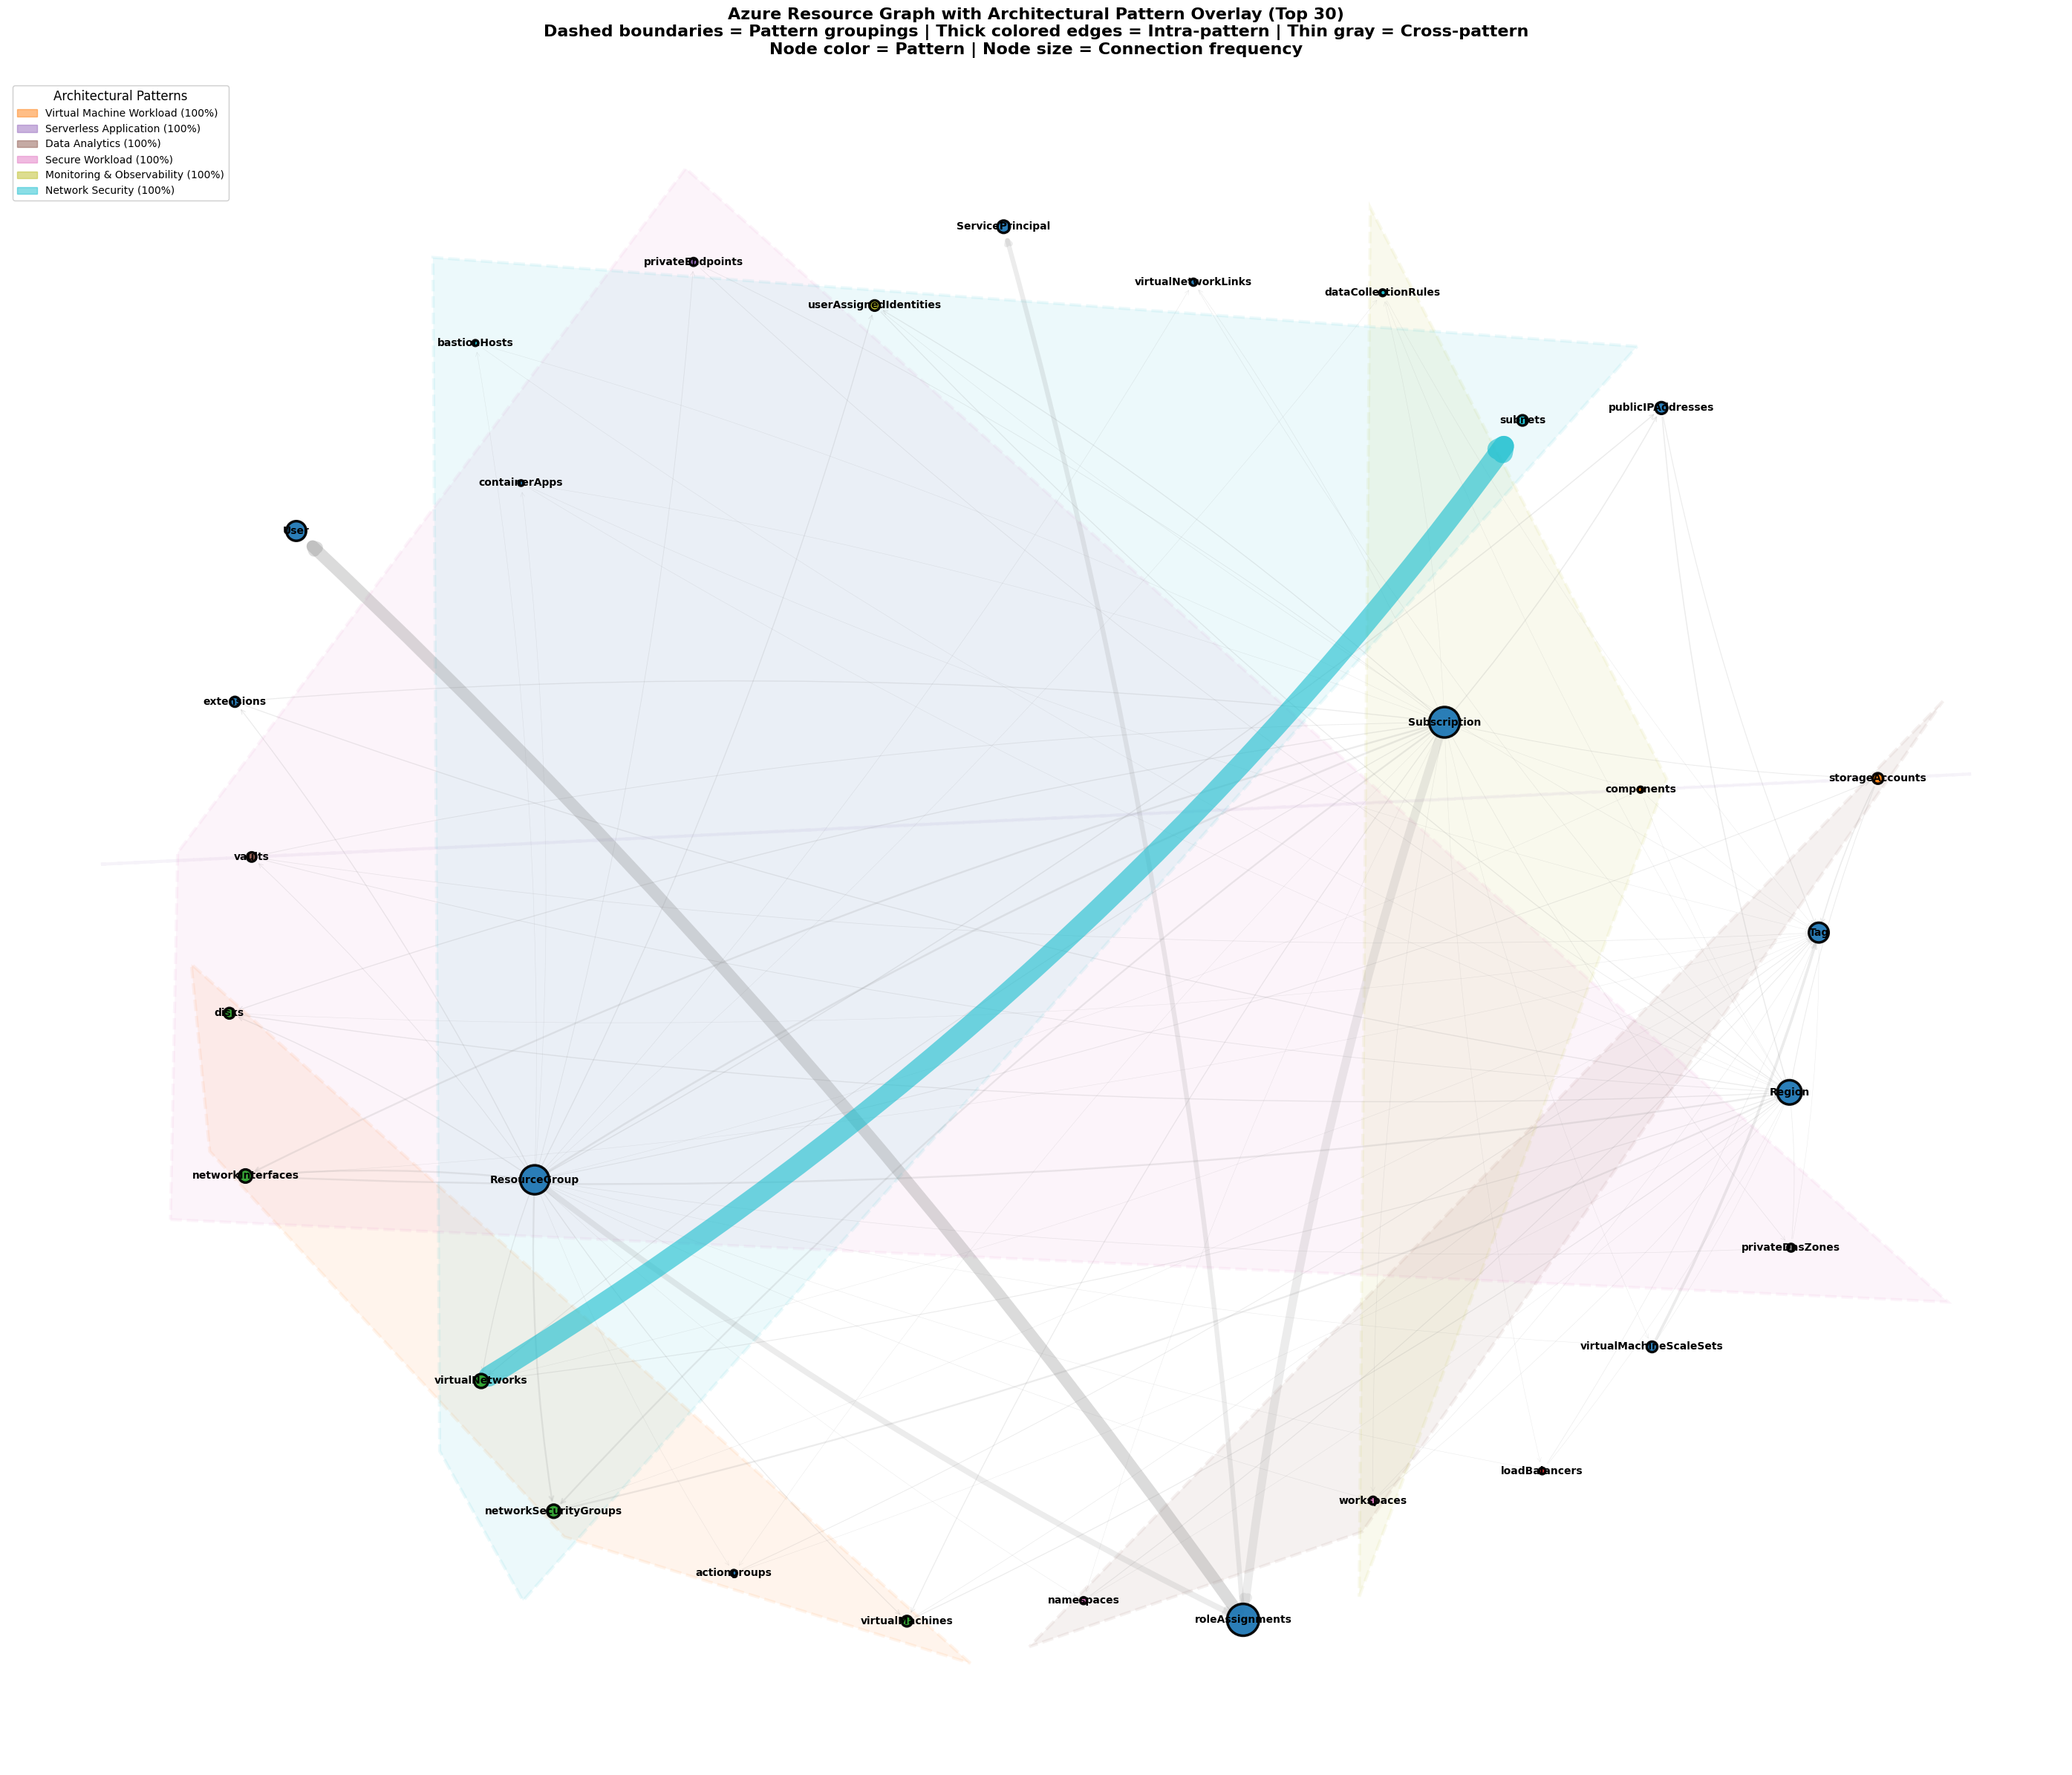


📊 Visualization:
   - Resource types: 30
   - Intra-pattern edges: 1 (colored)
   - Cross-pattern edges: 90 (gray)
   - Patterns detected: 10


In [8]:
# Step 4: Detect architectural patterns and visualize
pattern_matches = analyzer.detect_patterns(G, resource_type_counts)

print(f"📐 Detected {len(pattern_matches)} architectural patterns")

# Filter to show only the most significant nodes
top_n_nodes = 30
top_nodes = sorted(resource_type_counts.items(), key=lambda x: x[1], reverse=True)[
    :top_n_nodes
]
top_node_names = [name for name, _ in top_nodes]

# Create subgraph with only top nodes
G_filtered = G.subgraph(top_node_names).copy()

# Compute layout
pos = nx.spring_layout(G_filtered, k=3, iterations=50, seed=42)

# Assign patterns to nodes
node_pattern_map = {}
node_colors = []

for node in G_filtered.nodes():
    node_patterns = []
    for pattern_name, match in pattern_matches.items():
        if node in match["matched_resources"]:
            node_patterns.append(pattern_name)
    node_pattern_map[node] = node_patterns

    if node_patterns:
        best_pattern = max(
            node_patterns, key=lambda p: pattern_matches[p]["completeness"]
        )
        pattern_index = list(pattern_matches.keys()).index(best_pattern)
        node_colors.append(pattern_index)
    else:
        node_colors.append(-1)

# Calculate sizes and edge properties
node_sizes = [G_filtered.nodes[node]["count"] / 4 for node in G_filtered.nodes()]

# Separate pattern vs cross-pattern edges
pattern_edges = []
cross_pattern_edges = []
pattern_edge_widths = []
cross_pattern_edge_widths = []
pattern_edge_colors = []

for u, v, data in G_filtered.edges(data=True):
    freq = edge_counts.get((u, v), 0)
    edge_width = max(1, freq / 50)

    u_patterns = set(node_pattern_map.get(u, []))
    v_patterns = set(node_pattern_map.get(v, []))
    shared_patterns = u_patterns.intersection(v_patterns)

    if shared_patterns:
        pattern_edges.append((u, v))
        pattern_edge_widths.append(edge_width * 2.5)
        shared_pattern = list(shared_patterns)[0]
        pattern_index = list(pattern_matches.keys()).index(shared_pattern)
        pattern_edge_colors.append(pattern_index)
    else:
        cross_pattern_edges.append((u, v))
        cross_pattern_edge_widths.append(edge_width * 0.4)

# Create visualization
fig, ax = plt.subplots(1, 1, figsize=(28, 24))

# Draw pattern boundaries
cmap = plt.cm.tab10
pattern_legend = []

for pattern_idx, (pattern_name, match) in enumerate(pattern_matches.items()):
    pattern_nodes = [n for n in match["matched_resources"] if n in G_filtered.nodes()]

    if len(pattern_nodes) >= 3:
        try:
            points = np.array([[pos[node][0], pos[node][1]] for node in pattern_nodes])
            center = points.mean(axis=0)
            points_expanded = center + (points - center) * 1.15
            hull = ConvexHull(points_expanded)
            hull_points = points_expanded[hull.vertices]

            color = cmap(pattern_idx / len(pattern_matches))
            polygon = Polygon(
                hull_points,
                facecolor=color,
                alpha=0.08,
                edgecolor=color,
                linewidth=3,
                linestyle="--",
                zorder=1,
            )
            ax.add_patch(polygon)

            pattern_legend.append(
                Patch(
                    facecolor=color,
                    edgecolor=color,
                    label=f"{pattern_name} ({match['completeness']:.0f}%)",
                    alpha=0.5,
                )
            )
        except:
            pass

# Draw cross-pattern edges first (gray background)
if cross_pattern_edges:
    nx.draw_networkx_edges(
        G_filtered,
        pos,
        edgelist=cross_pattern_edges,
        width=cross_pattern_edge_widths,
        alpha=0.15,
        edge_color="gray",
        arrows=True,
        arrowsize=10,
        arrowstyle="->",
        connectionstyle="arc3,rad=0.05",
        ax=ax,
    )

# Draw pattern edges (colored by pattern)
if pattern_edges:
    for idx, (u, v) in enumerate(pattern_edges):
        edge_color = cmap(pattern_edge_colors[idx] / len(pattern_matches))
        nx.draw_networkx_edges(
            G_filtered,
            pos,
            edgelist=[(u, v)],
            width=pattern_edge_widths[idx],
            alpha=0.6,
            edge_color=[edge_color],
            arrows=True,
            arrowsize=15,
            arrowstyle="->",
            connectionstyle="arc3,rad=0.1",
            ax=ax,
        )

# Draw nodes
nx.draw_networkx_nodes(
    G_filtered,
    pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=cmap,
    vmin=-1,
    vmax=len(pattern_matches) - 1,
    alpha=0.95,
    edgecolors="black",
    linewidths=2.5,
    ax=ax,
)

# Draw labels
nx.draw_networkx_labels(G_filtered, pos, font_size=10, font_weight="bold", ax=ax)

# Add legend
if pattern_legend:
    ax.legend(
        handles=pattern_legend,
        loc="upper left",
        fontsize=10,
        framealpha=0.95,
        title="Architectural Patterns",
        title_fontsize=12,
    )

ax.set_title(
    f"Azure Resource Graph with Architectural Pattern Overlay (Top {top_n_nodes})\n"
    + "Dashed boundaries = Pattern groupings | Thick colored edges = Intra-pattern | "
    + "Thin gray = Cross-pattern\n"
    + "Node color = Pattern | Node size = Connection frequency",
    fontsize=16,
    fontweight="bold",
    pad=25,
)
ax.axis("off")
plt.tight_layout()
plt.show()

print("\n📊 Visualization:")
print(f"   - Resource types: {len(G_filtered.nodes())}")
print(f"   - Intra-pattern edges: {len(pattern_edges)} (colored)")
print(f"   - Cross-pattern edges: {len(cross_pattern_edges)} (gray)")
print(f"   - Patterns detected: {len(pattern_matches)}")

In [9]:
# Step 5: Export aggregated graph data to JSON using the analyzer
from pathlib import Path

output_file = Path("/tmp/azure_resource_graph_aggregated.json")
analyzer.export_graph_data(G, resource_type_counts, output_file, len(all_relationships))

print(f"✅ Aggregated graph data exported to: {output_file}")
print(f"   - {G.number_of_nodes()} unique resource types")
print(f"   - {G.number_of_edges()} unique relationship patterns")
print(f"   - Aggregated from {len(all_relationships):,} individual relationships")
print(
    "\nYou can use this JSON file with visualization tools like D3.js, Cytoscape, or Gephi"
)

✅ Aggregated graph data exported to: /tmp/azure_resource_graph_aggregated.json
   - 85 unique resource types
   - 276 unique relationship patterns
   - Aggregated from 12,560 individual relationships

You can use this JSON file with visualization tools like D3.js, Cytoscape, or Gephi


## 8. Orphaned Nodes Analysis 🔍

**NEW**: Identify resource types that are NOT part of any detected architectural pattern and automatically suggest new patterns!

In [10]:
# Step 6a: Identify orphaned nodes (not in any pattern)
orphaned_nodes = analyzer.identify_orphaned_nodes(G, pattern_matches)

print("🔍 Orphaned Nodes Analysis:")
print(f"   Total resource types: {G.number_of_nodes()}")
print(f"   Matched by patterns: {G.number_of_nodes() - len(orphaned_nodes)}")
print(f"   Orphaned (not in any pattern): {len(orphaned_nodes)}")
print(
    f"   Coverage: {((G.number_of_nodes() - len(orphaned_nodes)) / G.number_of_nodes() * 100):.1f}%"
)

print("\n📋 Top 10 Orphaned Nodes (by connection count):")
for idx, node in enumerate(orphaned_nodes[:10], 1):
    print(
        f"  {idx:2d}. {node['resource_type']:40s} : {node['connection_count']:5d} connections, {node['total_degree']:3d} degree"
    )
    if node["connected_to"]:
        print(f"      Connects to: {', '.join(node['connected_to'][:3])}")

🔍 Orphaned Nodes Analysis:
   Total resource types: 85
   Matched by patterns: 24
   Orphaned (not in any pattern): 61
   Coverage: 28.2%

📋 Top 10 Orphaned Nodes (by connection count):
   1. roleAssignments                          :  3821 connections,   6 degree
      Connects to: Subscription, ServicePrincipal, IdentityGroup
   2. Subscription                             :  3489 connections,  78 degree
      Connects to: EmailServices, containerApps, moveCollections
   3. ResourceGroup                            :  3155 connections,  78 degree
      Connects to: EmailServices, containerApps, moveCollections
   4. Region                                   :  2215 connections,  76 degree
      Connects to: CommunicationServices, networkSecurityGroups, containerGroups
   5. Tag                                      :  1464 connections,  39 degree
      Connects to: networkSecurityGroups, containerGroups, managedEnvironments
   6. User                                     :  1457 connectio

In [11]:
# Step 6b: Fetch documentation for a sample orphaned node
if orphaned_nodes:
    sample_node = orphaned_nodes[0]["resource_type"]
    doc = analyzer.fetch_microsoft_learn_documentation(sample_node)

    print(f"\n📚 Documentation Sample for '{sample_node}':")
    print(f"   Summary: {doc['summary']}")
    print("   Typical Uses:")
    for use in doc["typical_uses"][:3]:
        print(f"      - {use}")
    print(f"   Related Resources: {', '.join(doc['related_resources'][:5])}")
    print(f"   Microsoft Learn: {doc['url']}")


📚 Documentation Sample for 'roleAssignments':
   Summary: Azure roleAssignments resource - see Microsoft Learn for details
   Typical Uses:
      - See Microsoft Learn documentation
      - Common in Azure roleAssignments deployments
   Related Resources: 
   Microsoft Learn: https://learn.microsoft.com/en-us/search/?terms=site%3Alearn.microsoft.com/en-us/training%20Azure%20roleAssignments


In [12]:
# Step 6c: Suggest new architectural patterns
suggested_patterns = analyzer.suggest_new_patterns(orphaned_nodes, G)

print(f"💡 Pattern Suggestions: {len(suggested_patterns)} total")
print("=" * 80)

# Show top 5 suggestions by confidence
print("\n🏆 Top 5 Pattern Suggestions (by confidence):\n")
for idx, pattern in enumerate(suggested_patterns[:5], 1):
    print(f"{idx}. {pattern['suggested_name']}")
    print(f"   Confidence: {pattern.get('confidence', 0.0):.2f}")
    print(f"   Description: {pattern.get('description', 'N/A')[:100]}...")

    if pattern.get("action") == "UPDATE_EXISTING":
        print(
            f"   Action: Add '{pattern['resource_to_add']}' to '{pattern['target_pattern']}'"
        )
        print(
            f"   Rationale: {pattern['connection_count']} connections to this pattern"
        )
    else:
        req = pattern.get("required_resources", [])
        opt = pattern.get("optional_resources", [])
        print(f"   Required: {', '.join(req)}")
        if opt:
            print(f"   Optional: {', '.join(opt)}")
        print(f"   Internal connections: {pattern.get('internal_connections', 0)}")
    print()

# Show high-confidence suggestions
high_confidence = [p for p in suggested_patterns if p.get("confidence", 0) > 0.5]
print(
    f"📊 High-confidence suggestions (>0.5): {len(high_confidence)}/{len(suggested_patterns)}"
)

💡 Pattern Suggestions: 5 total

🏆 Top 5 Pattern Suggestions (by confidence):

1. Communicationservices + Serviceprincipal Pattern
   Confidence: 1.00
   Description: Azure CommunicationServices resource - see Microsoft Learn for details. Azure ServicePrincipal resou...
   Required: CommunicationServices, ServicePrincipal
   Optional: Tag, containerGroups, extensions, managedEnvironments, workbooks, flexibleServers, actiongroups, configurationStores, EmailServices, containerApps, staticSites, scheduledqueryrules, solutions, snapshots, searchServices, moveCollections, querypacks, galleries, runCommands, Domains, sshPublicKeys, accessConnectors, virtualNetworkLinks, factories, natGateways, roleAssignments, virtualMachineScaleSets, images, Subscription, templateSpecs, Region, databaseAccounts, jobs, automationAccounts, versions, builders, User, projects, applicationGatewayWebApplicationFirewallPolicies, metricalerts, dataCollectionEndpoints, grafana, sentinelPlatformServices, dnszones, Red

In [13]:
# Step 6d: Export orphaned nodes analysis to JSON
orphaned_analysis = {
    "orphaned_count": len(orphaned_nodes),
    "orphaned_nodes": orphaned_nodes,
    "suggested_patterns": suggested_patterns,
}

output_file = Path("/tmp/orphaned_nodes_analysis.json")
with open(output_file, "w") as f:
    json.dump(orphaned_analysis, f, indent=2)

print(f"✅ Orphaned nodes analysis exported to: {output_file}")
print(f"   - {len(orphaned_nodes)} orphaned resource types")
print(f"   - {len(suggested_patterns)} pattern suggestions")
print(f"   - {len(high_confidence)} high-confidence (>0.5) suggestions")

✅ Orphaned nodes analysis exported to: /tmp/orphaned_nodes_analysis.json
   - 61 orphaned resource types
   - 5 pattern suggestions
   - 5 high-confidence (>0.5) suggestions


## 9. Pattern Suggestions 💡

**NEW**: Automatically suggested patterns to improve coverage!

In [14]:
# Step 7: Calculate coverage improvement if patterns are implemented
current_coverage = (G.number_of_nodes() - len(orphaned_nodes)) / G.number_of_nodes()

# Estimate new coverage by counting unique resources in high-confidence patterns
new_covered_resources = set()
for pattern in high_confidence:
    if pattern.get("action") == "UPDATE_EXISTING":
        new_covered_resources.add(pattern["resource_to_add"])
    else:
        new_covered_resources.update(pattern.get("required_resources", []))
        new_covered_resources.update(pattern.get("optional_resources", []))

# Filter to only orphaned resources
orphaned_set = {node["resource_type"] for node in orphaned_nodes}
newly_covered = new_covered_resources.intersection(orphaned_set)
new_coverage = (
    G.number_of_nodes() - len(orphaned_nodes) + len(newly_covered)
) / G.number_of_nodes()

print("📈 Coverage Improvement Analysis:")
print(
    f"   Current coverage: {current_coverage:.1%} ({G.number_of_nodes() - len(orphaned_nodes)}/{G.number_of_nodes()} resource types)"
)
print(
    f"   Potential new coverage: {new_coverage:.1%} ({G.number_of_nodes() - len(orphaned_nodes) + len(newly_covered)}/{G.number_of_nodes()} resource types)"
)
print(
    f"   Improvement: +{(new_coverage - current_coverage):.1%} ({len(newly_covered)} additional types)"
)
print("\n💡 Recommendation:")
if len(high_confidence) > 0:
    print(
        f"   Implement {len(high_confidence)} high-confidence pattern suggestions to improve coverage"
    )
    print(
        f"   This would cover {len(newly_covered)} additional orphaned resource types"
    )
else:
    print(
        f"   Review all {len(suggested_patterns)} suggestions to identify patterns worth implementing"
    )

📈 Coverage Improvement Analysis:
   Current coverage: 28.2% (24/85 resource types)
   Potential new coverage: 100.0% (85/85 resource types)
   Improvement: +71.8% (61 additional types)

💡 Recommendation:
   Implement 5 high-confidence pattern suggestions to improve coverage
   This would cover 61 additional orphaned resource types


📊 Improved Pattern Coverage:
   Current: 28.2% with 10 patterns
   Improved: 100.0% with 11 patterns
   Improvement: +71.8% (61 additional types covered)



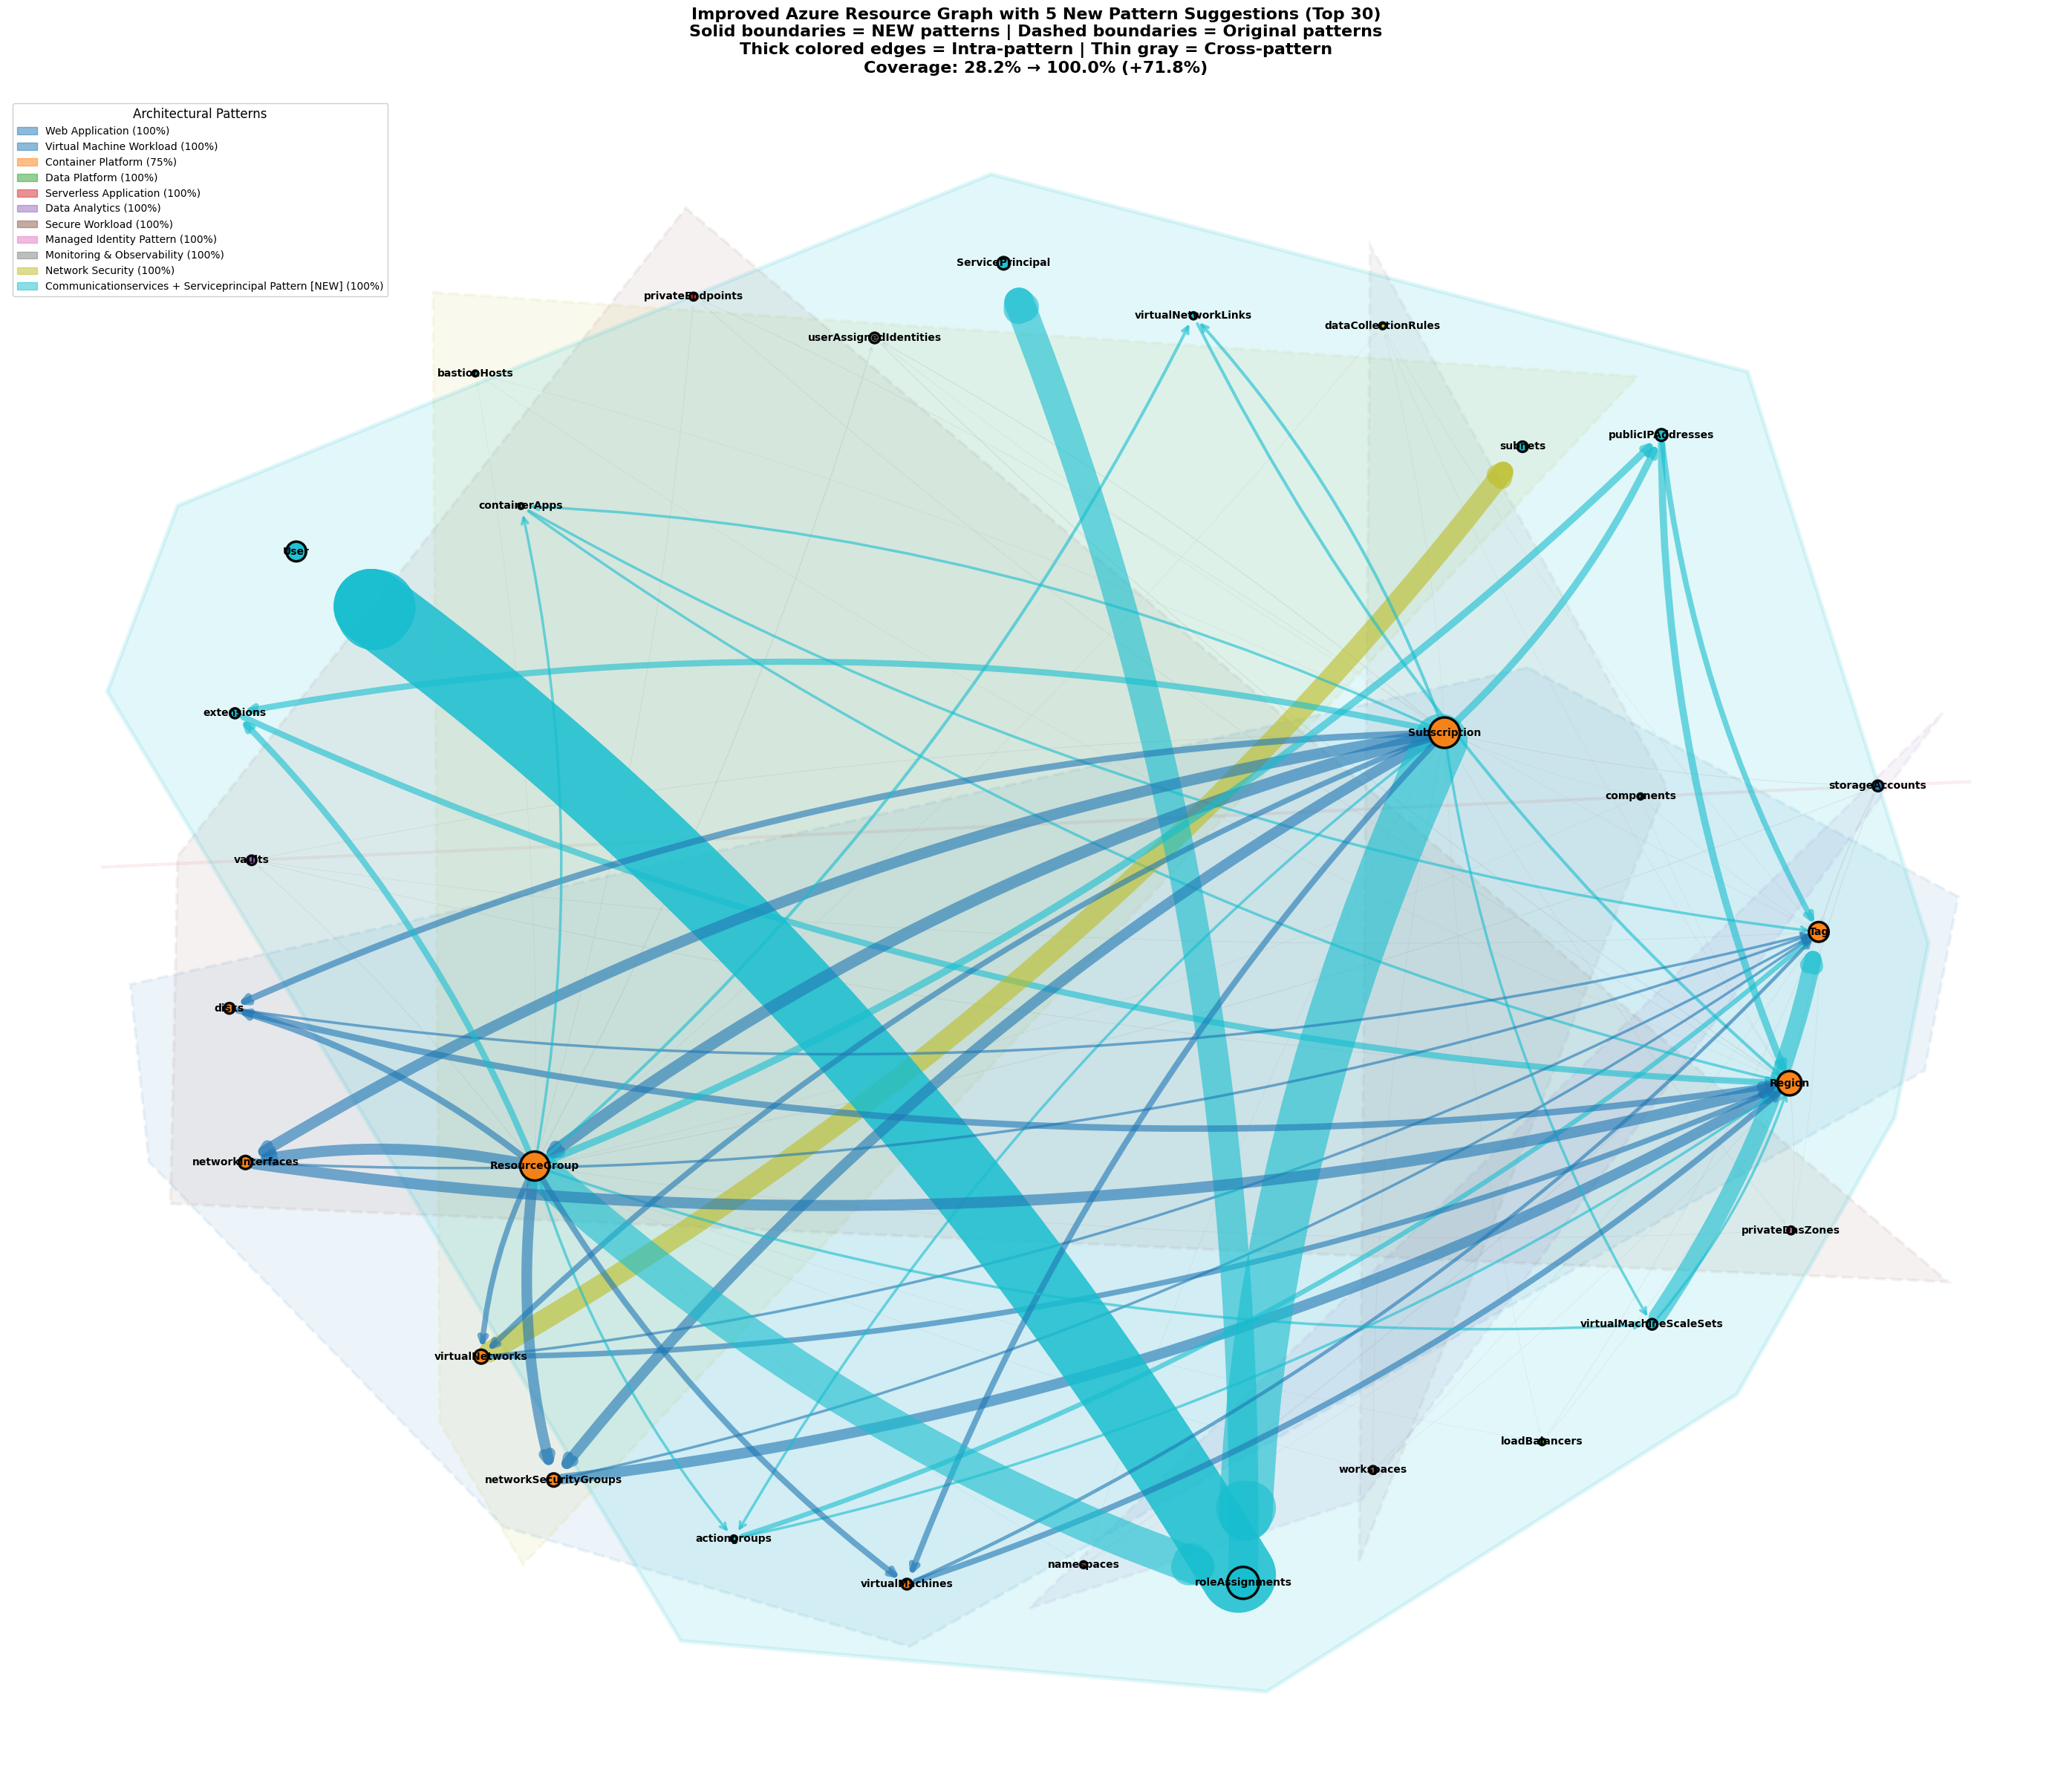


📊 Improved Visualization:
   - Resource types: 30
   - Intra-pattern edges: 49 (colored)
   - Cross-pattern edges: 42 (gray)
   - Original patterns: 10
   - NEW patterns: 1 (solid boundaries)

🆕 New Patterns Added to Graph:
   • Communicationservices + Serviceprincipal Pattern: 61 resources (13 visible)


In [15]:
# Step 7b: Visualize improved pattern graph with suggested patterns
# Create improved pattern matches by adding high-confidence suggestions
improved_pattern_matches = {}
for name, match in pattern_matches.items():
    improved_pattern_matches[name] = {
        "matched_resources": set(match["matched_resources"]),
        "completeness": match["completeness"],
        "source": "original",
    }

# Add new patterns from high-confidence suggestions
for pattern in high_confidence:
    if pattern.get("action") == "UPDATE_EXISTING":
        target = pattern["target_pattern"]
        if target in improved_pattern_matches:
            improved_pattern_matches[target]["matched_resources"].add(
                pattern["resource_to_add"]
            )
    else:
        pattern_name = pattern["suggested_name"]
        required = set(pattern.get("required_resources", []))
        optional = set(pattern.get("optional_resources", []))
        improved_pattern_matches[pattern_name] = {
            "matched_resources": required.union(optional),
            "completeness": pattern.get("confidence", 0.5) * 100,
            "source": "suggested",
        }

# Calculate improved coverage
improved_orphaned_nodes = analyzer.identify_orphaned_nodes(G, improved_pattern_matches)
improved_coverage = (
    G.number_of_nodes() - len(improved_orphaned_nodes)
) / G.number_of_nodes()

print("📊 Improved Pattern Coverage:")
print(f"   Current: {current_coverage:.1%} with {len(pattern_matches)} patterns")
print(
    f"   Improved: {improved_coverage:.1%} with {len(improved_pattern_matches)} patterns"
)
print(
    f"   Improvement: +{(improved_coverage - current_coverage):.1%} ({len(orphaned_nodes) - len(improved_orphaned_nodes)} additional types covered)\n"
)

# Recreate the visualization with improved patterns
# Use same filtered graph
G_filtered_improved = G.subgraph(top_node_names).copy()

# Use same layout for consistency
pos_improved = pos.copy()

# Assign improved patterns to nodes
node_pattern_map_improved = {}
node_colors_improved = []

for node in G_filtered_improved.nodes():
    node_patterns = []
    for pattern_name, match in improved_pattern_matches.items():
        if node in match["matched_resources"]:
            node_patterns.append(pattern_name)
    node_pattern_map_improved[node] = node_patterns

    if node_patterns:
        best_pattern = max(
            node_patterns, key=lambda p: improved_pattern_matches[p]["completeness"]
        )
        pattern_index = list(improved_pattern_matches.keys()).index(best_pattern)
        node_colors_improved.append(pattern_index)
    else:
        node_colors_improved.append(-1)

# Separate pattern vs cross-pattern edges for improved graph
pattern_edges_improved = []
cross_pattern_edges_improved = []
pattern_edge_widths_improved = []
cross_pattern_edge_widths_improved = []
pattern_edge_colors_improved = []

for u, v, data in G_filtered_improved.edges(data=True):
    freq = edge_counts.get((u, v), 0)
    edge_width = max(1, freq / 50)

    u_patterns = set(node_pattern_map_improved.get(u, []))
    v_patterns = set(node_pattern_map_improved.get(v, []))
    shared_patterns = u_patterns.intersection(v_patterns)

    if shared_patterns:
        pattern_edges_improved.append((u, v))
        pattern_edge_widths_improved.append(edge_width * 2.5)
        shared_pattern = list(shared_patterns)[0]
        pattern_index = list(improved_pattern_matches.keys()).index(shared_pattern)
        pattern_edge_colors_improved.append(pattern_index)
    else:
        cross_pattern_edges_improved.append((u, v))
        cross_pattern_edge_widths_improved.append(edge_width * 0.4)

# Create improved visualization
fig, ax = plt.subplots(1, 1, figsize=(28, 24))

# Draw pattern boundaries
cmap = plt.cm.tab10
pattern_legend_improved = []

for pattern_idx, (pattern_name, match) in enumerate(improved_pattern_matches.items()):
    pattern_nodes = [
        n for n in match["matched_resources"] if n in G_filtered_improved.nodes()
    ]

    if len(pattern_nodes) >= 3:
        try:
            points = np.array(
                [
                    [pos_improved[node][0], pos_improved[node][1]]
                    for node in pattern_nodes
                ]
            )
            center = points.mean(axis=0)
            points_expanded = center + (points - center) * 1.15
            hull = ConvexHull(points_expanded)
            hull_points = points_expanded[hull.vertices]

            color = cmap(pattern_idx / len(improved_pattern_matches))

            # Use different line style for suggested patterns
            if match.get("source") == "suggested":
                linestyle = "-"  # Solid line for new patterns
                linewidth = 4
                alpha = 0.12
            else:
                linestyle = "--"  # Dashed for original
                linewidth = 3
                alpha = 0.08

            polygon = Polygon(
                hull_points,
                facecolor=color,
                alpha=alpha,
                edgecolor=color,
                linewidth=linewidth,
                linestyle=linestyle,
                zorder=1,
            )
            ax.add_patch(polygon)

            label_suffix = " [NEW]" if match.get("source") == "suggested" else ""
            pattern_legend_improved.append(
                Patch(
                    facecolor=color,
                    edgecolor=color,
                    label=f"{pattern_name}{label_suffix} ({match['completeness']:.0f}%)",
                    alpha=0.5,
                )
            )
        except:
            pass
    elif len(pattern_nodes) > 0:
        # Still add to legend even if too small to draw
        color = cmap(pattern_idx / len(improved_pattern_matches))
        label_suffix = " [NEW]" if match.get("source") == "suggested" else ""
        pattern_legend_improved.append(
            Patch(
                facecolor=color,
                edgecolor=color,
                label=f"{pattern_name}{label_suffix} ({match['completeness']:.0f}%)",
                alpha=0.5,
            )
        )

# Draw cross-pattern edges first (gray background)
if cross_pattern_edges_improved:
    nx.draw_networkx_edges(
        G_filtered_improved,
        pos_improved,
        edgelist=cross_pattern_edges_improved,
        width=cross_pattern_edge_widths_improved,
        alpha=0.15,
        edge_color="gray",
        arrows=True,
        arrowsize=10,
        arrowstyle="->",
        connectionstyle="arc3,rad=0.05",
        ax=ax,
    )

# Draw pattern edges (colored by pattern)
if pattern_edges_improved:
    for idx, (u, v) in enumerate(pattern_edges_improved):
        edge_color = cmap(
            pattern_edge_colors_improved[idx] / len(improved_pattern_matches)
        )
        nx.draw_networkx_edges(
            G_filtered_improved,
            pos_improved,
            edgelist=[(u, v)],
            width=pattern_edge_widths_improved[idx],
            alpha=0.6,
            edge_color=[edge_color],
            arrows=True,
            arrowsize=15,
            arrowstyle="->",
            connectionstyle="arc3,rad=0.1",
            ax=ax,
        )

# Draw nodes
nx.draw_networkx_nodes(
    G_filtered_improved,
    pos_improved,
    node_size=node_sizes,
    node_color=node_colors_improved,
    cmap=cmap,
    vmin=-1,
    vmax=len(improved_pattern_matches) - 1,
    alpha=0.95,
    edgecolors="black",
    linewidths=2.5,
    ax=ax,
)

# Draw labels
nx.draw_networkx_labels(
    G_filtered_improved, pos_improved, font_size=10, font_weight="bold", ax=ax
)

# Add legend
if pattern_legend_improved:
    ax.legend(
        handles=pattern_legend_improved,
        loc="upper left",
        fontsize=10,
        framealpha=0.95,
        title="Architectural Patterns",
        title_fontsize=12,
    )

ax.set_title(
    f"Improved Azure Resource Graph with {len(high_confidence)} New Pattern Suggestions (Top {top_n_nodes})\n"
    + "Solid boundaries = NEW patterns | Dashed boundaries = Original patterns\n"
    + "Thick colored edges = Intra-pattern | Thin gray = Cross-pattern\n"
    + f"Coverage: {current_coverage:.1%} → {improved_coverage:.1%} (+{(improved_coverage - current_coverage):.1%})",
    fontsize=16,
    fontweight="bold",
    pad=25,
)
ax.axis("off")
plt.tight_layout()
plt.show()

print("\n📊 Improved Visualization:")
print(f"   - Resource types: {len(G_filtered_improved.nodes())}")
print(f"   - Intra-pattern edges: {len(pattern_edges_improved)} (colored)")
print(f"   - Cross-pattern edges: {len(cross_pattern_edges_improved)} (gray)")
print(
    f"   - Original patterns: {len([m for m in improved_pattern_matches.values() if m.get('source') == 'original'])}"
)
print(
    f"   - NEW patterns: {len([m for m in improved_pattern_matches.values() if m.get('source') == 'suggested'])} (solid boundaries)"
)

# List new patterns
new_patterns = [
    (name, match)
    for name, match in improved_pattern_matches.items()
    if match.get("source") == "suggested"
]
if new_patterns:
    print("\n🆕 New Patterns Added to Graph:")
    for name, match in new_patterns:
        resources_in_view = [
            r for r in match["matched_resources"] if r in top_node_names
        ]
        print(
            f"   • {name}: {len(match['matched_resources'])} resources ({len(resources_in_view)} visible)"
        )

## 11. Architecture Distribution Analysis 📊

**NEW**: Compute distribution scores for each architectural pattern using the weighted pattern graph.

This analysis quantifies pattern prevalence through a composite score combining:
- **Instance count** (30%): How many times the pattern appears
- **Resource count** (25%): How many resources are involved  
- **Connection strength** (25%): Sum of edge weights within the pattern
- **Centrality** (20%): Betweenness centrality of pattern nodes

This is used for **proportional tenant replication** - ensuring target tenants maintain the same architectural balance as source tenants.

In [16]:
# NOTE: This demonstrates the architecture distribution API.
# For actual replication, see architecture_based_replication.ipynb which includes
# the complete workflow with configuration coherence.

# Step 8a: Prepare mock pattern_resources for demonstration
# In real usage, this comes from ArchitecturePatternReplicator after finding instances
print("🔍 Architecture Distribution Analysis Demo\n")
print("Note: This is a demonstration using mock data.")
print("For real replication workflows, use architecture_based_replication.ipynb\n")

# Create mock pattern_resources (pattern_name -> list of instances)
# Each instance is a list of resource IDs
pattern_resources_mock = {}

for pattern_name, match in pattern_matches.items():
    # Simulate instances by grouping matched resources
    # In real usage, these would be actual ResourceGroup-based instances
    matched = match["matched_resources"]
    if matched:
        # Create mock instances (3-5 resources per instance)
        num_instances = max(1, len(matched) // 3)
        instances = []
        for i in range(num_instances):
            # Each instance is a list of resource IDs
            instance = [
                f"/subscriptions/mock/resourceGroups/rg-{pattern_name}-{i}/providers/Microsoft.{rt}/{rt}-{i}"
                for rt in matched[: min(3, len(matched))]
            ]
            instances.append(instance)
        pattern_resources_mock[pattern_name] = instances

print(f"Created mock data for {len(pattern_resources_mock)} patterns:")
for name, instances in pattern_resources_mock.items():
    print(f"  • {name}: {len(instances)} instances")

🔍 Architecture Distribution Analysis Demo

Note: This is a demonstration using mock data.
For real replication workflows, use architecture_based_replication.ipynb

Created mock data for 10 patterns:
  • Web Application: 1 instances
  • Virtual Machine Workload: 1 instances
  • Container Platform: 1 instances
  • Data Platform: 1 instances
  • Serverless Application: 1 instances
  • Data Analytics: 1 instances
  • Secure Workload: 1 instances
  • Managed Identity Pattern: 1 instances
  • Monitoring & Observability: 1 instances
  • Network Security: 1 instances


In [17]:
# Step 8b: Compute architecture distribution
distribution = analyzer.compute_architecture_distribution(pattern_resources_mock, G)

print("\n📊 Architecture Distribution Scores:\n")
print("=" * 80)

for pattern_name, data in sorted(
    distribution.items(), key=lambda x: x[1]["distribution_score"], reverse=True
):
    print(f"\n{data['rank']}. {pattern_name}")
    print(f"   Distribution Score: {data['distribution_score']:.1f}")
    print(f"   Source Instances: {data['source_instances']}")
    print(f"   Source Resources: {data['source_resources']}")
    print("   Breakdown:")
    breakdown = data["breakdown"]
    print(
        f"      Instance Count:      {breakdown['instance_count_pct']:5.1f}% (weight: 30%)"
    )
    print(
        f"      Resource Count:      {breakdown['resource_count_pct']:5.1f}% (weight: 25%)"
    )
    print(
        f"      Connection Strength: {breakdown['connection_strength_pct']:5.1f}% (weight: 25%)"
    )
    print(
        f"      Centrality:          {breakdown['centrality_pct']:5.1f}% (weight: 20%)"
    )

print("\n" + "=" * 80)
print("\nℹ️  Higher scores indicate more prevalent patterns in the tenant.")
print("ℹ️  Use these scores for proportional instance selection during replication.")


📊 Architecture Distribution Scores:


1. Network Security
   Distribution Score: 6.8
   Source Instances: 1
   Source Resources: 3
   Breakdown:
      Instance Count:       10.0% (weight: 30%)
      Resource Count:       10.0% (weight: 25%)
      Connection Strength:   3.2% (weight: 25%)
      Centrality:            2.3% (weight: 20%)

2. Virtual Machine Workload
   Distribution Score: 6.0
   Source Instances: 1
   Source Resources: 3
   Breakdown:
      Instance Count:       10.0% (weight: 30%)
      Resource Count:       10.0% (weight: 25%)
      Connection Strength:   0.0% (weight: 25%)
      Centrality:            2.4% (weight: 20%)

3. Container Platform
   Distribution Score: 6.0
   Source Instances: 1
   Source Resources: 3
   Breakdown:
      Instance Count:       10.0% (weight: 30%)
      Resource Count:       10.0% (weight: 25%)
      Connection Strength:   0.0% (weight: 25%)
      Centrality:            2.3% (weight: 20%)

4. Web Application
   Distribution Score: 5.5
   So

In [18]:
# Step 8c: Compute pattern targets for proportional sampling
target_instance_count = 20  # Example: replicate 20 instances

pattern_targets = analyzer.compute_pattern_targets(distribution, target_instance_count)

print(f"\n🎯 Proportional Instance Allocation for {target_instance_count} Instances:\n")
print("=" * 80)

total_source_instances = sum(data["source_instances"] for data in distribution.values())

for pattern_name in sorted(
    pattern_targets.keys(), key=lambda x: pattern_targets[x], reverse=True
):
    target_n = pattern_targets[pattern_name]
    source_n = distribution[pattern_name]["source_instances"]
    score = distribution[pattern_name]["distribution_score"]

    if target_n > 0:
        proportion = (
            score / sum(d["distribution_score"] for d in distribution.values())
        ) * 100
        print(f"  • {pattern_name}:")
        print(
            f"      Source: {source_n} instances ({source_n / total_source_instances * 100:.1f}% of source)"
        )
        print(
            f"      Target: {target_n} instances ({target_n / target_instance_count * 100:.1f}% of target)"
        )
        print(
            f"      Calculation: {target_instance_count} × {proportion:.1f}% = {target_instance_count * proportion / 100:.2f} → {target_n}"
        )
        print()

print("=" * 80)
print(
    f"\n✅ Total allocated: {sum(pattern_targets.values())}/{target_instance_count} instances"
)
print(
    "\nℹ️  This ensures target tenant maintains the same architectural balance as source."
)


🎯 Proportional Instance Allocation for 20 Instances:

  • Virtual Machine Workload:
      Source: 1 instances (10.0% of source)
      Target: 3 instances (15.0% of target)
      Calculation: 20 × 10.5% = 2.09 → 3

  • Container Platform:
      Source: 1 instances (10.0% of source)
      Target: 3 instances (15.0% of target)
      Calculation: 20 × 10.5% = 2.09 → 3

  • Network Security:
      Source: 1 instances (10.0% of source)
      Target: 3 instances (15.0% of target)
      Calculation: 20 × 11.9% = 2.37 → 3

  • Web Application:
      Source: 1 instances (10.0% of source)
      Target: 2 instances (10.0% of target)
      Calculation: 20 × 9.6% = 1.92 → 2

  • Data Platform:
      Source: 1 instances (10.0% of source)
      Target: 2 instances (10.0% of target)
      Calculation: 20 × 9.6% = 1.92 → 2

  • Serverless Application:
      Source: 1 instances (10.0% of source)
      Target: 2 instances (10.0% of target)
      Calculation: 20 × 9.6% = 1.92 → 2

  • Data Analytics:
    

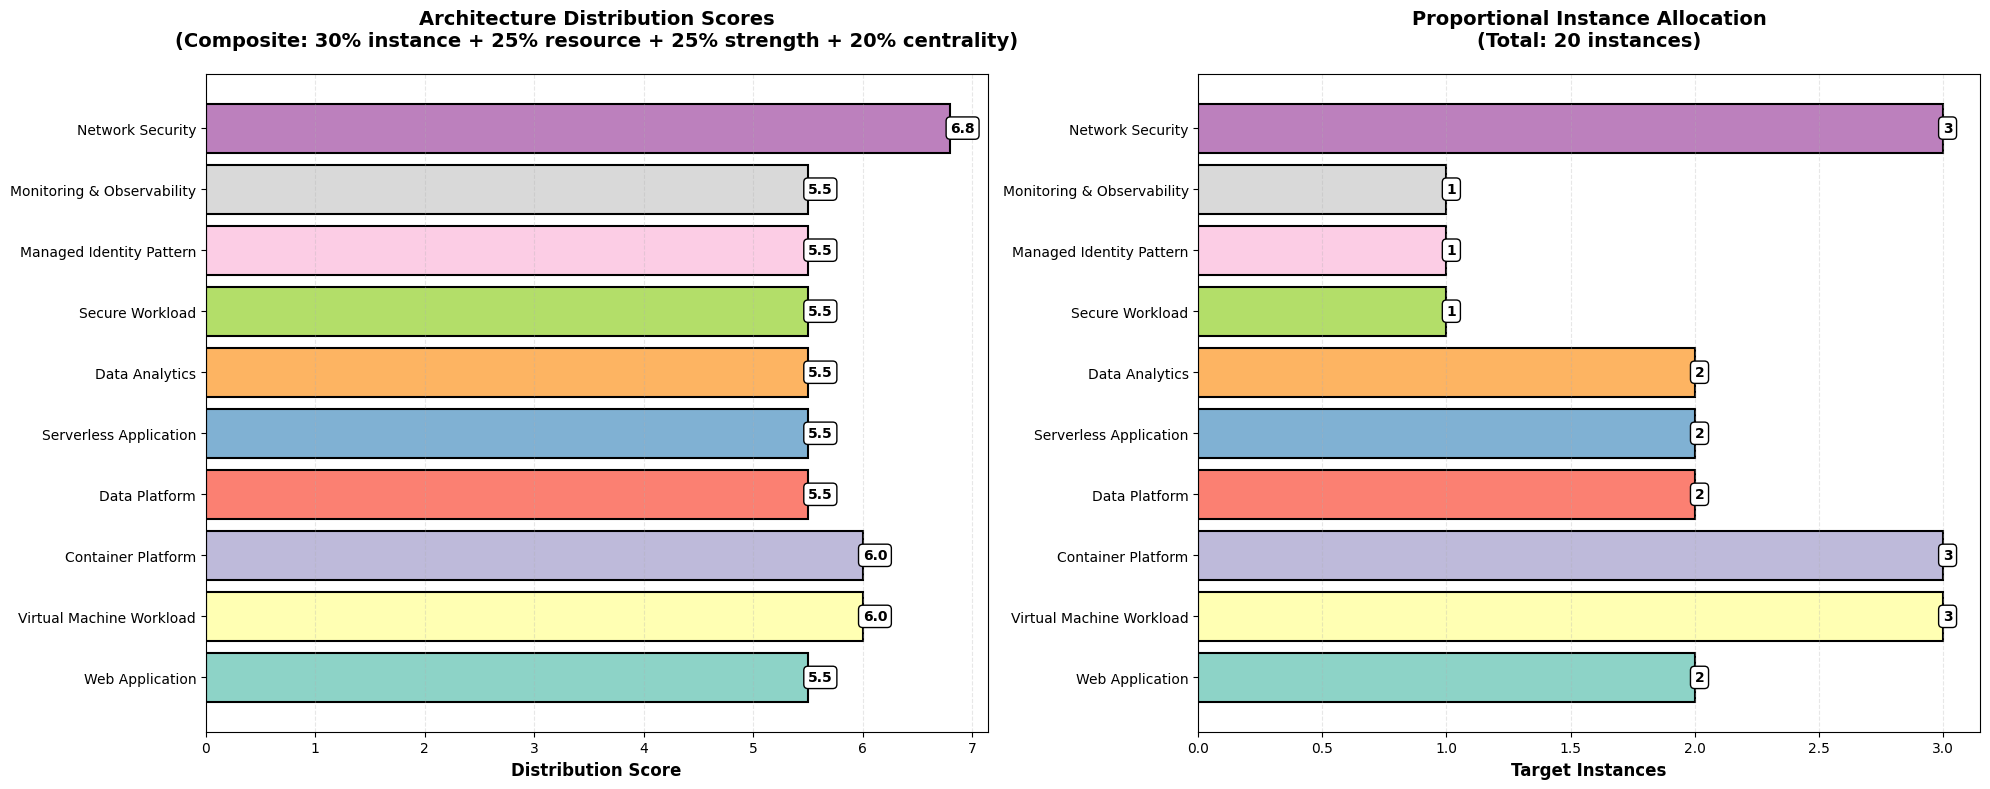


📊 Visualization shows:
   Left:  Distribution scores (pattern prevalence)
   Right: Proportional instance allocation for replication


In [19]:
# Step 8d: Visualize distribution with bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Left: Distribution scores
patterns = list(distribution.keys())
scores = [distribution[p]["distribution_score"] for p in patterns]
colors_dist = plt.cm.Set3(range(len(patterns)))

bars1 = ax1.barh(patterns, scores, color=colors_dist, edgecolor="black", linewidth=1.5)
ax1.set_xlabel("Distribution Score", fontsize=12, fontweight="bold")
ax1.set_title(
    "Architecture Distribution Scores\n(Composite: 30% instance + 25% resource + 25% strength + 20% centrality)",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
ax1.grid(axis="x", alpha=0.3, linestyle="--")

# Add value labels
for bar in bars1:
    width = bar.get_width()
    ax1.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.1f}",
        ha="left",
        va="center",
        fontweight="bold",
        fontsize=10,
        bbox=dict(
            boxstyle="round,pad=0.3", facecolor="white", edgecolor="black", linewidth=1
        ),
    )

# Right: Target instance allocation
patterns_with_targets = [p for p in patterns if pattern_targets.get(p, 0) > 0]
targets = [pattern_targets[p] for p in patterns_with_targets]
colors_target = [colors_dist[patterns.index(p)] for p in patterns_with_targets]

bars2 = ax2.barh(
    patterns_with_targets,
    targets,
    color=colors_target,
    edgecolor="black",
    linewidth=1.5,
)
ax2.set_xlabel("Target Instances", fontsize=12, fontweight="bold")
ax2.set_title(
    f"Proportional Instance Allocation\n(Total: {target_instance_count} instances)",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
ax2.grid(axis="x", alpha=0.3, linestyle="--")

# Add value labels
for bar in bars2:
    width = bar.get_width()
    ax2.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f"{int(width)}",
        ha="left",
        va="center",
        fontweight="bold",
        fontsize=10,
        bbox=dict(
            boxstyle="round,pad=0.3", facecolor="white", edgecolor="black", linewidth=1
        ),
    )

plt.tight_layout()
plt.show()

print("\n📊 Visualization shows:")
print("   Left:  Distribution scores (pattern prevalence)")
print("   Right: Proportional instance allocation for replication")

In [20]:
# Step 8e: Export distribution analysis
output_file = Path("/tmp/architecture_distribution.json")
analyzer.export_architecture_distribution(distribution, output_file)

print(f"✅ Architecture distribution exported to: {output_file}")
print(f"   - {len(distribution)} patterns analyzed")
print("   - Distribution scores computed using 4 metrics")
print("   - Proportional sampling targets calculated")
print("\n📖 For complete replication workflow with configuration coherence:")
print("   See: notebooks/architecture_based_replication.ipynb")

✅ Architecture distribution exported to: /tmp/architecture_distribution.json
   - 10 patterns analyzed
   - Distribution scores computed using 4 metrics
   - Proportional sampling targets calculated

📖 For complete replication workflow with configuration coherence:
   See: notebooks/architecture_based_replication.ipynb


### Key Insights from Architecture Distribution

**Distribution Scores** quantify pattern prevalence in your tenant:
- Higher scores = more prevalent patterns
- Used for proportional instance selection during replication
- Ensures target tenants are statistically representative of source

**Proportional Sampling** maintains architectural balance:
- If 40% of source instances are "VM Workload", target will have 40%
- Prevents over-representing rare patterns
- Ensures cost estimates are accurate

**Use Cases**:
- **Representative test environments**: Scaled-down but architecturally faithful
- **Cost modeling**: Estimate costs based on actual distribution
- **Architecture standardization**: Identify which patterns to standardize
- **Migration planning**: Prioritize migration based on pattern prevalence

See [ARCHITECTURAL_PATTERN_ANALYSIS.md](../docs/ARCHITECTURAL_PATTERN_ANALYSIS.md#architecture-distribution-analysis) for complete details.

## 10. Cleanup 🧹

In [21]:
# Close both the driver and analyzer connections
driver.close()
analyzer.close()
print("✅ Connections closed")

✅ Connections closed
